# Tutorial 8
We show how to train a profitable RL agent on portfolio managemnt with EIIE algorithm on US stock market  with more technical indicators.

In [ ]:
!git clone -b 1.0.0 https://github.com/TradeMaster-NTU/TradeMaster.git

Cloning into 'TradeMaster'...
remote: Enumerating objects: 6371, done.
remote: Counting objects: 100% (1591/1591), done.
remote: Compressing objects: 100% (604/604), done.
remote: Total 6371 (delta 1017), reused 1531 (delta 972), pack-reused 4780
Receiving objects: 100% (6371/6371), 383.15 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (3233/3233), done.
Updating files: 100% (392/392), done.


In [ ]:
%cd '/content/TradeMaster'

/content/TradeMaster


In [ ]:
!pip install -r requirements.txt

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [ ]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = '/content/TradeMaster'
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
import pandas as pd
set_seed(2023)

## Step 2.1: Load Configs
Load default config from the file `configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py`

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)


Below is an overview of the original dataset before the technical indicators were generated.

In [ ]:
cfg["data"]

{'type': 'PortfolioManagementDataset',
 'data_path': 'data/portfolio_management/dj30',
 'train_path': 'data/portfolio_management/dj30/train.csv',
 'valid_path': 'data/portfolio_management/dj30/valid.csv',
 'test_path': 'data/portfolio_management/dj30/test.csv',
 'tech_indicator_list': ['zopen',
  'zhigh',
  'zlow',
  'zadjcp',
  'zclose',
  'zd_5',
  'zd_10',
  'zd_15',
  'zd_20',
  'zd_25',
  'zd_30'],
 'length_day': 10,
 'initial_amount': 100000,
 'transaction_cost_pct': 0.001,
 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}

## Step 2.2: Download data from Yahoo Finance then Generate new technical indicators

First modify the `indicator` in `configs/data_preprocessor/yahoofinance/dj30.py`. When `indicator='alpha158'`, this means that all technical indicators are generated. When `indicator='alpha158_novolume'`, this means generating volume-independent technical indicators. When `indicator='basic'`, it means that only the simplest technical indicators shown above are generated.

Run the following Python program to download data from Yahoo Finance and generate new technical indicators. In this case, we are downloading the DJ30 dataset and generating the volume-independent Alpha158 technical indicator, which includes the following: 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ROC', 'MA', 'STD', 'BETA', 'MAX', 'MIN', 'QTLU', 'QTLD', 'RANK', 'RSV', 'IMAX', 'IMIN', 'IMXD', 'CORR', 'CORD', 'CNTP', 'CNTN', 'CNTD', 'SUMP', 'SUMN', 'SUMD', 'VMA', 'VSTD', 'WVMA', 'VSUMP', 'VSUMN', 'VSUMD'.

This step will take approximately 5 minutes.





In [ ]:
!python /content/TradeMaster/tools/data_preprocessor/yahoofinance/dj30.py

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

As new files have been generated, the paths for the training, validation, and test sets need to be updated in the config file. 

In [ ]:
cfg["data"]['train_path']='workdir/dj30/train.csv'
cfg["data"]['valid_path']='workdir/dj30/valid.csv'
cfg["data"]['test_path']='workdir/dj30/test.csv'

Additionally, since the number of indicators has increased, a new list of technical indicators needs to be exported based on the newly generated files.

In [ ]:
cols_to_drop = ['Unnamed: 0',
          'open',
          'high',
          'low',
          'close',
          'adjclose',
          'volume',
          'tic',
          'date',]
get_indicator_list = pd.read_csv('workdir/dj30/train.csv')
get_indicator_list = get_indicator_list.drop(labels=cols_to_drop, axis=1)
cfg["data"]['tech_indicator_list']=get_indicator_list.columns.tolist()

Now you can see the new dataset paths and the expanded list of technical indicators.

In [ ]:
cfg["data"]

{'type': 'PortfolioManagementDataset',
 'data_path': 'data/portfolio_management/dj30',
 'train_path': 'workdir/dj30/train.csv',
 'valid_path': 'workdir/dj30/valid.csv',
 'test_path': 'workdir/dj30/test.csv',
 'tech_indicator_list': ['zopen',
  'zhigh',
  'zlow',
  'zadjcp',
  'zclose',
  'zd_5',
  'zd_10',
  'zd_15',
  'zd_20',
  'zd_25',
  'zd_30',
  'zd_60',
  'KMID',
  'KLEN',
  'KMID2',
  'KUP',
  'KUP2',
  'KLOW',
  'KLOW2',
  'KSFT',
  'KSFT2',
  'ROC5',
  'MA5',
  'STD5',
  'BETA5',
  'RSQR5',
  'MAX5',
  'MIN5',
  'QTLU5',
  'QTLD5',
  'RANK5',
  'RSV5',
  'IMAX5',
  'IMIN5',
  'IMXD5',
  'CNTP5',
  'CNTN5',
  'CNTD5',
  'SUMP5',
  'SUMN5',
  'SUMD5',
  'ROC10',
  'MA10',
  'STD10',
  'BETA10',
  'RSQR10',
  'MAX10',
  'MIN10',
  'QTLU10',
  'QTLD10',
  'RANK10',
  'RSV10',
  'IMAX10',
  'IMIN10',
  'IMXD10',
  'CNTP10',
  'CNTN10',
  'CNTD10',
  'SUMP10',
  'SUMN10',
  'SUMD10',
  'ROC20',
  'MA20',
  'STD20',
  'BETA20',
  'RSQR20',
  'MAX20',
  'MIN20',
  'QTLU20',
  'QTLD20

## Step 3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments

In [ ]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [ ]:
train_environment.df.head()

,open,high,low,close,adjclose,volume,tic,date,zopen,zhigh,...,RSV60,IMAX60,IMIN60,IMXD60,CNTP60,CNTN60,CNTD60,SUMP60,SUMN60,SUMD60
0,0.936384,1.004464,0.907924,0.999442,0.850644,535796800,AAPL,2000-01-03,-0.063093,0.005025,...,1.502317,0.933333,0.933333,0.000000,0.516667,0.466667,0.050000,0.558062,0.441938,0.116124
0,47.995617,47.995617,45.515598,45.880306,33.436111,6471267,AXP,2000-01-03,0.046105,0.046105,...,74.835474,0.000000,0.000000,0.000000,0.400000,0.600000,-0.200000,0.355306,0.644694,-0.289388
0,41.437500,41.687500,39.812500,40.187500,25.940277,2638200,BA,2000-01-03,0.031104,0.037325,...,384.626019,0.683333,0.683333,0.000000,0.400000,0.600000,-0.200000,0.429893,0.570107,-0.140213
0,23.843750,24.500000,23.843750,24.312500,13.171329,5055000,CAT,2000-01-03,-0.019280,0.007712,...,1082.250908,0.016667,0.000000,0.000278,0.366667,0.633333,-0.266667,0.423712,0.576288,-0.152576
0,54.968750,55.125000,51.781250,54.031250,38.065075,53076000,CSCO,2000-01-03,0.017351,0.020243,...,361.054796,0.000000,0.000000,0.000000,0.416667,0.583333,-0.166667,0.423214,0.576786,-0.153572


## Step 5: Build Net 
Update information on the state and action dimension. Crreate networks and optimizer for EIIE.

In [ ]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

## Step 6: Build Loss Function

In [ ]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [ ]:
transition = build_transition(cfg)


## Step 8: Build Agent

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: /content/TradeMaster/work_dir/portfolio_management_dj30_eiie_eiie_adam_mse


## Step 10: RL Agent Training
Train the EIIE agent based on the config and save results in workdir. Each epoch may take several hours due to the greatly increased number of technical indicators.

In [ ]:
trainer.train_and_valid()

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -88.892373%  |  -0.306930  | 1.975111%  |  97.955820%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -23.456653%  |  -0.646248  | 1.218745%  |  29.353698%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -25.073072%  |   0.098129  | 1.999204%  |  81.250002%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

## Step 11: RL Agent Testing

In [ ]:
trainer.test();

Resume checkpoint /content/TradeMaster/work_dir/portfolio_management_dj30_eiie_eiie_adam_mse/checkpoints/best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -12.028011%  |  -0.324568  | 1.063050%  |  31.134292%  |
+--------------+-------------+------------+--------------+


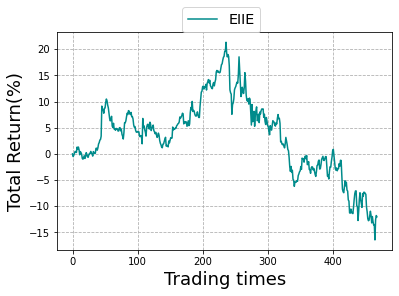

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")